<a href="https://colab.research.google.com/github/DDiekmann/Applied-Verification-Lab-Neural-Networks/blob/main/Tutorials/Alpha_Beta_Crown.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial for α,β-CROWN Robustness Verification 





---


*This tutorial shows the robustness verification of a neural network trained on 
the MNIST dataset with use of α,β-CROWN.*


---



**α,β-CROWN**
α,β-CROWN is an open-source neural network verifier. The code can be found on [their website](https://github.com/huanzhang12/alpha-beta-CROWN). 

In this tutorial we will first go through the installation of α,β-CROWN and train our own network. This network is to be verified later in the tutorial. Therefore, the verfication must be configured first. 

## Installation

This installation is based on another [tutorial](https://colab.research.google.com/drive/1mJTOmq2qHxMycHUzBepBN47QWcxda3ov#scrollTo=Y0toepwVIFTG). 

First we will set up our miniconda environment. 

In [ ]:
%%capture
%%bash
%env PYTHONPATH=
MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

Python in version 3.7 is installed into the environment. 

In [ ]:
%%capture
%%bash
conda install --channel defaults conda python=3.7 --yes
conda update --channel defaults --all --yes

In [ ]:
%%capture
import sys
sys.path
!ls /usr/local/lib/python3.7/dist-packages
_ = (sys.path
        .append("/usr/local/lib/python3.7/site-packages"))

In order to use the library, we have to clone the corresponding git-repository.

In [ ]:
%%capture
# Uninstall existing Pytorch on Colab, which might be incompatible or buggy.
# Note that the alpha beta crown library is tested on Pytorch 1.8.2 LTS, and other versions might be incompatible.(according to reference tutorial)
# !pip uninstall --yes torch torchvision torchaudio torchtext
!git clone https://github.com/huanzhang12/alpha-beta-CROWN.git

The environment is created. 

In [ ]:
%%capture
%%bash
# Remove the old environment, if necessary.
conda env remove --name alpha-beta-crown
conda env create -f alpha-beta-CROWN/complete_verifier/environment.yml  # install all dependents into the alpha-beta-crown environment

In [ ]:
%cd alpha-beta-CROWN/complete_verifier/

/content/alpha-beta-CROWN/complete_verifier


As explained on [the website of the α,β-project](https://github.com/huanzhang12/alpha-beta-CROWN), it is nessasary to create a configuration file in order to load the data. 

## Configure verification

Now we want to verifiy a model. Therefore, we create a file called my_example_config.yaml which configures parameters for verification. 
The model is defined as followed: 


```
def mnist_6_100():
    model = nn.Sequential(
        Flatten(),
        nn.Linear(784,100),
        nn.ReLU(),
        nn.Linear(100,100),
        nn.ReLU(),
        nn.Linear(100,100),
        nn.ReLU(),
        nn.Linear(100,100),
        nn.ReLU(),
        nn.Linear(100,100),
        nn.ReLU(),
        nn.Linear(100, 10)
    )
    return model
```

It contains six linear layers and uses the ReLU activation function.

We start with a very basic configuration file, which means that most parameters are set to default.

In [ ]:
%%writefile exp_configs/my_example_config.yaml
general:
  # device to run verifier
  device: cpu 
  # Complete verification verifier. 
  # "bab": branch and bound with beta-CROWN; 
  # "mip": mixed integer programming (MIP) formulation; 
  # "bab-refine": branch and bound with intermediate layer bounds computed by MIP.
  complete_verifier: bab
model:
  # name of the model (provided by library, see above)
  name: mnist_6_100
  # Load pretrained model from this specified path.
  path: models/eran/mnist_6_100_nat.pth
data:
  # Dataset name. Dataset must be defined in utils.py.
  dataset: MNIST_ERAN_UN
  # Std vector used in data preprocessing.
  std: [1.0]
  # Mean vector used in data preprocessing.
  mean: [0.0]
specification:
  # Set perturbation size (Lp norm). 
  # If not set, a default value may be used based on dataset loader.
  epsilon: 0.026
solver:
  alpha-crown:
    # Number of iterations for alpha-CROWN incomplete verifier.
    iteration: 10
attack:
  # Early stop PGD when an adversarial example is found.
  pgd_early_stop: true  

Overwriting exp_configs/my_example_config.yaml


## Verification of network with α,β-CROWN

Now we only have to run our verification. 

First, we activate our environment.
Then we call the robustness_verifier on our configured yaml-file. The robustness_verifier is a class provided by the α,β-CROWN-library for Lp norm robustness verification and is often used to certify the robustness of a neural network. 
By setting start to 0 and end to 3, we indicate that only images 0 to 3 from the dataset should be verified. This is done for performance reasons. 
We finish by deactivating the environment.


In [ ]:
%%writefile run.sh

source activate alpha-beta-crown
python robustness_verifier.py --config exp_configs/my_example_config.yaml --start 0 --end 3
conda deactivate

Writing run.sh


In [ ]:
!chmod 777 run.sh
!./run.sh

Configurations:

general:
  device: cpu
  seed: 100
  conv_mode: patches
  deterministic: false
  double_fp: false
  loss_reduction_func: sum
  record_bounds: false
  mode: verified-acc
  complete_verifier: bab
  enable_incomplete_verification: true
  get_crown_verified_acc: false
model:
  path: models/eran/mnist_6_100_nat.pth
  name: mnist_6_100
data:
  start: 0
  end: 3
  num_outputs: 10
  mean: [0.0]
  std: [1.0]
  pkl_path: null
  dataset: MNIST_ERAN_UN
  data_filter_path: null
  data_idx_file: null
specification:
  type: lp
  norm: .inf
  epsilon: 0.026
solver:
  alpha-crown:
    lr_alpha: 0.1
    iteration: 1
    share_slopes: false
    no_joint_opt: false
  beta-crown:
    batch_size: 64
    lr_alpha: 0.01
    lr_beta: 0.05
    lr_decay: 0.98
    optimizer: adam
    iteration: 50
    beta: true
    beta_warmup: true
  mip:
    parallel_solvers: null
    solver_threads: 1
    refine_neuron_timeout: 15
    refine_neuron_time_percentage: 0.8
    early_stop: true
bab:
  max_domains:

## Try configuration options

α,β-CROWN provides a number of different parameters that can be used for verification. An overview is given here: 


```
general:
  device: cuda  # Select device to run verifier, cpu or cuda (GPU).
  seed: 100  # Random seed.
  conv_mode: patches  # Convolution mode during bound propagation: "patches" mode (default) is very efficient, but may not support all architecture; "matrix" mode is slow but supports all architectures.
  deterministic: false  # Run code in CUDA deterministic mode, which has slower performance but better reproducibility.
  double_fp: false  # Use double precision floating point. GPUs with good double precision support are preferable (NVIDIA P100, V100, A100; AMD Radeon Instinc MI50, MI100).
  loss_reduction_func: sum  # When batch size is not 1, this reduction function is applied to reduce the bounds into a single number (options are "sum" and "min").
  mode: verified-acc  # Verify against all labels ("verified-acc" mode), or just the runnerup labels ("runnerup" mode), or using a specified label in dataset ("speicify-target" mode, only used for oval20). Mode can also be set as "crown-only-verified-acc" or "alpha-crown-only-verified-acc", which quickly computes the verified accuracy over the entire dataset via CROWN or alpha-CROWN.
  complete_verifier: bab  # Complete verification verifier. "bab": branch and bound with beta-CROWN; "mip": mixed integer programming (MIP) formulation; "bab-refine": branch and bound with intermediate layer bounds computed by MIP.
  enable_incomplete_verification: true  # Enable/Disable initial alpha-CROWN incomplete verification (this can save GPU memory when disabled).
model:
  path: null  # Load pretrained model from this specified path.
  name: please_specify_model_name  # Name of model. Model must be defined in the load_verification_dataset() function in utils.py.
data:
  start: 0  # Start from the i-th property in specified dataset.
  end: 10000  # End with the (i-1)-th property in the dataset.
  num_outputs: 10  # Number of classes for classification problem.
  mean: 0.0  # Mean vector used in data preprocessing.
  std: 1.0  # Std vector used in data preprocessing.
  pkl_path: null  # Load properties to verify from a .pkl file (only used for oval20 dataset).
  dataset: CIFAR  # Dataset name. Dataset must be defined in utils.py.
  data_idx_file: null  # A text file with a list of example IDs to run.
specification:
  type: lp  # Type of verification specification. "lp" = L_p norm, "bounds" = element-wise lower and upper bound provided by dataloader.
  norm: .inf  # Lp-norm for epsilon perturbation in robustness verification (1, 2, inf).
  epsilon: null  # Set perturbation size (Lp norm). If not set, a default value may be used based on dataset loader.
solver:
  alpha-crown:
    lr_alpha: 0.1  # Learning rate for the optimizable parameter alpha in alpha-CROWN bound.
    iteration: 100  # Number of iterations for alpha-CROWN incomplete verifier.
    share_slopes: false  # Share some alpha variables to save memory at the cost of slightly looser bounds.
    no_joint_opt: false  # Run alpha-CROWN bounds without joint optimization (only optimize alpha for the last layer bound).
  beta-crown:
    batch_size: 64  # Batch size in beta-CROWN (number of parallel splits).
    lr_alpha: 0.01  # Learning rate for optimizing alpha during branch and bound.
    lr_beta: 0.05  # Learning rate for optimizing beta during branch and bound.
    lr_decay: 0.98  # Learning rate decay factor during optimization. Need to use a larger value like 0.99 or 0.995 when you increase the number of iterations.
    optimizer: adam  # Optimizer used for alpha and beta optimization.
    iteration: 50  # Number of iteration for optimizing alpha and beta during branch and bound.
  mip:
    parallel_solvers: null  # Number of multi-processes for mip solver. Each process computes a mip bound for an intermediate neuron. Default (None) is to auto detect the number of CPU cores (note that each process may use multiple threads, see the next option).
    solver_threads: 1  # Number of threads for echo mip solver process (default is to use 1 thread for each solver process).
    refine_neuron_timeout: 15  # MIP timeout threshold for improving each intermediate layer bound (in seconds).
    refine_neuron_time_percentage: 0.8  # Percentage (x100%) of time used for improving all intermediate layer bounds using mip. Default to be 0.8*timeout.
bab:
  max_domains: 200000  # Max number of subproblems in branch and bound.
  decision_thresh: 0  # Decision threshold of lower bounds. When lower bounds are greater than this value, verification is successful. Set to 0 for robustness verification.
  timeout: 360  # Timeout (in second) for verifying one image/property.
  branching:
    method: kfsb  # Branching heuristic. babsr is fast but less accurate; fsb is slow but most accurate; kfsb is usualy a balance.
    candidates: 3  # Number of candidates to consider when using fsb or kfsb. More leads to slower but better branching.
    reduceop: min  # Reduction operation to compute branching scores from two sides of a branch (min or max). max can work better on some models.
attack:
  pgd_order: before  # Run PGD before/after incomplete verification, or skip it.
  enable_mip_attack: false  # Use MIP (Gurobi) based attack if PGD cannot find a successful adversarial example.
  pgd_steps: 100  # Steps of PGD attack.
  pgd_restarts: 30  # Number of random PGD restarts.
  pgd_early_stop: true  # Early stop PGD when an adversarial example is found.
  pgd_lr_decay: 0.99  # Learning rate decay factor used in PGD attack.
  pgd_alpha: auto  # Step size of PGD attack. Default (auto) is epsilon/4.
  ```



##Try out another epsilon
Now it's up to you! Try different configuration options and see how it influences the result! \\
For example: What do you think changes with a changed value for Epsilon? 
(Expand the cell in order to see the resulting configuration file)

In [ ]:
%%writefile exp_configs/my_example_config.yaml
general:
  # device to run verifier
  device: cpu 
  # Complete verification verifier. 
  # "bab": branch and bound with beta-CROWN; 
  # "mip": mixed integer programming (MIP) formulation; 
  # "bab-refine": branch and bound with intermediate layer bounds computed by MIP.
  complete_verifier: bab
model:
  # name of the model (provided by library, see above)
  name: mnist_6_100
  # Load pretrained model from this specified path.
  path: models/eran/mnist_6_100_nat.pth
data:
  # Dataset name. Dataset must be defined in utils.py.
  dataset: MNIST_ERAN_UN
  # Std vector used in data preprocessing.
  std: [1.0]
  # Mean vector used in data preprocessing.
  mean: [0.0]
specification:
  # Set perturbation size (Lp norm). 
  # If not set, a default value may be used based on dataset loader.
  epsilon: 1
solver:
  alpha-crown:
    # Number of iterations for alpha-CROWN incomplete verifier.
    iteration: 10  
attack:
  # Early stop PGD when an adversarial example is found.
  pgd_early_stop: true   

Overwriting exp_configs/my_example_config.yaml


## Run your new configuration file
So, what do you expect with your new epsilon? 

In [ ]:
!./run.sh

Configurations:

general:
  device: cpu
  seed: 100
  conv_mode: patches
  deterministic: false
  double_fp: false
  loss_reduction_func: sum
  record_bounds: false
  mode: verified-acc
  complete_verifier: bab
  enable_incomplete_verification: true
  get_crown_verified_acc: false
model:
  path: models/eran/mnist_6_100_nat.pth
  name: mnist_6_100
data:
  start: 0
  end: 3
  num_outputs: 10
  mean: [0.0]
  std: [1.0]
  pkl_path: null
  dataset: MNIST_ERAN_UN
  data_filter_path: null
  data_idx_file: null
specification:
  type: lp
  norm: .inf
  epsilon: 1
solver:
  alpha-crown:
    lr_alpha: 0.1
    iteration: 20
    share_slopes: false
    no_joint_opt: false
  beta-crown:
    batch_size: 64
    lr_alpha: 0.01
    lr_beta: 0.05
    lr_decay: 0.98
    optimizer: adam
    iteration: 50
    beta: true
    beta_warmup: true
  mip:
    parallel_solvers: null
    solver_threads: 1
    refine_neuron_timeout: 15
    refine_neuron_time_percentage: 0.8
    early_stop: true
bab:
  max_domains: 20

As you can see, the larger epsilon makes the attack much more likely to succeed. This is because a larger epsilon allows a greater change in the original image.

##Different norms
α,β-CROWN offers the possibility to use different norms for the verification of the networks. 
###L1 Norm
The L1 norm is also known as Manhattan Distance or Taxicab norm. The L1 norm for a vector $x$ is calculated by $||x||_1$=  $\sum\nolimits_{i=1}^n |x_i|^2$. In the case of the plot below it is $||a||_1$=  $|a_1| + |a_2|$ = 3 + 4 = 7. 



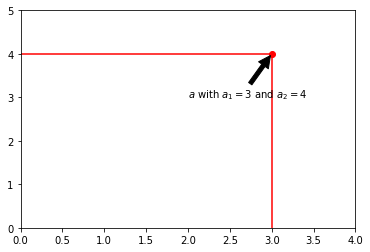

In [41]:
import matplotlib.pyplot as plt

plt.plot([3], [4], 'ro')
plt.axis([0, 4, 0, 5])
plt.plot([3, 0], [4, 4],color="red")
plt.plot([3, 3], [0, 4],color="red")
plt.annotate('$a$ with $a_1=3$ and $a_2=4$', xy=(3, 4), xytext=(2, 3),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )
plt.show()

###L2 Norm
The L2 norm is also known as the Euclidean norm. 
###L3 Norm

## Customization on custom model and data
Alpha beta crown can be easily be run on customized models and data. 
We will use it on a custom model and the cifar10 dataset. 
it can as well support other arbitrary datasets. 


In [ ]:
%%writefile custom_model_data.py
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import arguments
import numpy as np


def simple_conv_model(in_channel, out_dim):
    """Simple Convolutional Neural Network model."""
    model = nn.Sequential(
        nn.Conv2d(in_channel, 16, 4, stride=2, padding=0),
        nn.ReLU(),
        nn.Conv2d(16, 32, 4, stride=2, padding=0),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(32*6*6,100),
        nn.ReLU(),
        nn.Linear(100, out_dim)
    )
    return model


def cifar10_dataloader(eps, use_bounds=False):
    """Example dataloader. For MNIST and CIFAR you can actually use existing ones in utils.py."""
    assert eps is not None
    database_path = os.path.join(os.path.dirname(os.path.abspath(__file__)), 'datasets')
    # You can access the mean and std stored in config file.
    mean = torch.tensor(arguments.Config["data"]["mean"])
    std = torch.tensor(arguments.Config["data"]["std"])
    normalize = transforms.Normalize(mean=mean, std=std)
    test_data = datasets.CIFAR10(database_path, train=False, download=True, transform=transforms.Compose([transforms.ToTensor(), normalize]))
    # Load entire dataset.
    testloader = torch.utils.data.DataLoader(test_data, batch_size=10000, shuffle=False, num_workers=4)
    X, labels = next(iter(testloader))
    if use_bounds:
        # Option 1: for each example, we return its element-wise lower and upper bounds.
        # If you use this option, set --spec_type ("specifications"->"type" in config) to 'bound'.
        absolute_max = torch.reshape((1. - mean) / std, (1, -1, 1, 1))
        absolute_min = torch.reshape((0. - mean) / std, (1, -1, 1, 1))
        # Be careful with normalization.
        new_eps = torch.reshape(eps / std, (1, -1, 1, 1))
        data_max = torch.min(X + new_eps, absolute_max)
        data_min = torch.max(X - new_eps, absolute_min)
        # In this case, the epsilon does not matter here.
        ret_eps = None
    else:
        # Option 2: return a single epsilon for all data examples, as well as clipping lower and upper bounds.
        # Set data_max and data_min to be None if no clip. For CIFAR-10 we clip to [0,1].
        data_max = torch.reshape((1. - mean) / std, (1, -1, 1, 1))
        data_min = torch.reshape((0. - mean) / std, (1, -1, 1, 1))
        if eps is None:
            raise ValueError('You must specify an epsilon')
        # Rescale epsilon.
        ret_eps = torch.reshape(eps / std, (1, -1, 1, 1))
    return X, labels, data_max, data_min, ret_eps

Overwriting custom_model_data.py


#Using the configuration for the custom model and data


In [ ]:
%%writefile exp_configs/tutorial_cifar_example.yaml
general:
  mode: verified-acc
model:
  # Use the simple_conv_model() model in "your_model_data.py".
  name: Customized("custom_model_data", "simple_conv_model", in_channel=3, out_dim=10)
  path: models/eran/cifar_conv_small_pgd.pth
data:
  # Use the cifar10_dataloader()  in "custom_model_data.py".
  dataset: Customized("custom_model_data", "cifar10_dataloader")
  mean: [0.4914, 0.4822, 0.4465]
  std: [0.2023, 0.1994, 0.201]
specification:
  epsilon: 0.00784313725  # 2./255.
attack:
  pgd_restarts: 100
solver:
  beta-crown:
    batch_size: 2048
    iteration: 20
bab:
  max_domains: 5000000
  timeout: 300

Writing exp_configs/tutorial_cifar_example.yaml


# checking robustness on custom data and model


In [ ]:
%%bash
source activate alpha-beta-crown
python robustness_verifier.py --config exp_configs/tutorial_cifar_example.yaml --start 3 --end 4
conda deactivate

Configurations:

general:
  device: cuda
  seed: 100
  conv_mode: patches
  deterministic: false
  double_fp: false
  loss_reduction_func: sum
  record_bounds: false
  mode: verified-acc
  complete_verifier: bab
  enable_incomplete_verification: true
  get_crown_verified_acc: false
model:
  path: models/eran/cifar_conv_small_pgd.pth
  name: 'Customized("custom_model_data", "simple_conv_model", in_channel=3, out_dim=10)'
data:
  start: 3
  end: 4
  num_outputs: 10
  mean: [0.4914, 0.4822, 0.4465]
  std: [0.2023, 0.1994, 0.201]
  pkl_path: null
  dataset: 'Customized("custom_model_data", "cifar10_dataloader")'
  data_filter_path: null
  data_idx_file: null
specification:
  type: lp
  norm: .inf
  epsilon: 0.00784313725
solver:
  alpha-crown:
    lr_alpha: 0.1
    iteration: 100
    share_slopes: false
    no_joint_opt: false
  beta-crown:
    batch_size: 2048
    lr_alpha: 0.01
    lr_beta: 0.05
    lr_decay: 0.98
    optimizer: adam
    iteration: 20
    beta: true
    beta_warmup: true

170499072it [00:11, 15193853.83it/s]                               
/usr/local/envs/alpha-beta-crown/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Traceback (most recent call last):
  File "robustness_verifier.py", line 599, in <module>
    main()
  File "robustness_verifier.py", line 238, in main
    model_ori, all_data_max, all_data_min = model_ori.to(arguments.Config["general"]["device"]), data_max.to(arguments.Config["general"]["device"]), data_min.to(arguments.Config["general"]["device"])
  File "/usr/local/envs/alpha-beta-crown/lib/python3.7/site-packages/torch/nn/modules/module.py", line